Goal 
==============================
In this notebook, I am trying to get the **best weights to predict _NYT Picked comments_**.

In [42]:
from sklearn import svm, linear_model, preprocessing, cross_validation
from sklearn.feature_selection import SelectPercentile, f_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import *
from bokeh.charts import Histogram,Bar, Scatter
output_notebook()


# Data Loading

We will load the following data

- **feature matrix**
- **label vector**

$$
{\rm feature~matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
x_{11} & x_{12} & \cdots & x_{1D}\\
x_{21} & x_{22} & \cdots & x_{2D}\\
x_{31} & x_{32} & \cdots & x_{3D}\\
\vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{ND}\\
\end{matrix}
\right]
$$

$$
{\rm label~vector:~~~} {\bf y}~=~ [y_1, y_2, y_3, \cdots y_N]
$$

Here there are $N$ samples and $D$ features.


In [43]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])

score = pd.DataFrame()

for i in range(3):
    filename = 'data/score' + str(i+1) + '.csv' 
    score = score.append( pd.read_csv(filename) )
    
                       
score4 = pd.read_csv('data/score4.csv')
score5 = pd.read_csv('data/score5.csv')
# score3 = pd.read_csv('data/score3.csv')

score4 = score4[score4.EditorsSelection == 1]

score5 = score5[score5.EditorsSelection == 1]

score = score.append(score4)
score = score.append(score5)

score = score.reset_index(drop=True)

In [44]:


score_picked = score[score.EditorsSelection == 1]
score_picked = score_picked.reset_index(drop=True)


In [45]:
score_not_picked = score[score.EditorsSelection == 0]
score_not_picked = score_not_picked.reset_index(drop=True)

rows = np.random.choice(score_not_picked.index.values, 94)

score_not_picked_sampled = score_not_picked.ix[rows]

final_score = score_not_picked_sampled.append(score_picked)
final_score = final_score.reset_index(drop=True)

In [46]:
final_score

,AVGBrevity,AVGPersonalXP,AVGPicks,AVGReadability,AVGRecommendationScore,AVGcommentspermonth,ApproveDate,ArticleRelevance,Brevity,CommentSequence,...,NumberofRecords,PersonalXP,Readability,RecommendationCount,RecommendationScore,Status_Accepted,TimesPeople,UserComments,UserID,commentBody
0,15.085471,15.154988,1.282051,28.565802,1.397633,1.497870,1425851960,49.082085,16.967509,14352898,...,NaN,0.000000,42.129630,0,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,53402379,Yik Yak doesn\'t rely on media acknowledgement...
1,8.321844,19.889734,0.943396,14.788518,0.814313,2.330188,1425966574,3.087706,5.054152,14363966,...,NaN,0.000000,23.379630,0,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,8609152,Are you dissing their names or the fact that t...
2,14.760712,14.404685,0.793167,26.855848,1.406728,7.691795,1425844327,1.059546,4.693141,14352408,...,NaN,23.076923,19.212963,4,21.582455,approved,1,api.nytimes.com/svc/community/v2/comments/user...,1456724,Oh my goodness. People made fun of her name! B...
3,19.129173,24.933044,46.153846,34.579439,8.088235,0.000000,"1,423,847,148",10.368471,20.070423,"14,126,795",...,1,0.000000,28.018223,1,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,71028788,Policy driven by data might also be contributi...
4,23.875181,7.554040,0.000000,39.737599,5.656109,0.751499,"1,423,772,692",17.716395,31.690141,"14,119,416",...,1,0.000000,52.847380,5,25.536018,approved,1,api.nytimes.com/svc/community/v2/comments/user...,10016661,"The problem, one might say, is reasoning from ..."
5,19.318895,37.838228,9.240246,31.970805,4.864718,11.436881,"1,423,847,625",12.024532,16.549296,"14,127,363",...,1,0.000000,41.230068,1,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,65526003,This man appears to be a wise leader. Not onl...
6,8.321844,19.889734,0.943396,14.788518,0.814313,2.330188,1425966604,1.824055,2.888087,14364074,...,NaN,37.500000,13.888889,0,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,8609152,What about the parents who are using it?
7,28.758689,12.374101,15.789474,49.352353,22.213622,1.189874,"1,423,779,308",20.567288,28.169014,"14,121,252",...,1,0.000000,41.230068,1,0.000000,approved,1,api.nytimes.com/svc/community/v2/comments/user...,69361826,You say that 98% of black people are law abidi...
8,37.325677,21.221989,19.565217,53.778952,28.388747,0.810210,"1,423,765,175",26.208020,49.295775,"14,118,415",...,1,10.185185,59.681093,15,42.967062,approved,1,api.nytimes.com/svc/community/v2/comments/user...,66160987,This is refreshingly frank and articulate. The...
9,26.173585,23.020081,0.000000,39.271028,5.441176,0.552573,"1,423,765,252",11.365034,11.267606,"14,118,483",...,1,0.000000,35.079727,12,39.426573,approved,1,api.nytimes.com/svc/community/v2/comments/user...,62013988,It is indeed refreshing to hear frank comments...


In [47]:
# merged_score = score

# merged_score = score.reindex(np.random.permutation(score.index))

merged_score = final_score

feature_label = ['ArticleRelevance','Brevity','ConversationalRelevance','PersonalXP','Readability'];
selected_score = merged_score[['ArticleRelevance','Brevity','ConversationalRelevance','PersonalXP','Readability']]
result = merged_score['EditorsSelection']


X_original = selected_score.values.astype(float)
X = preprocessing.scale(X_original)

# print X.mean(axis=0)
# print X.std(axis=0) 
y = result.values
# y = np.array([1,1,0,1,1,0,7,8,9,10])

In [48]:
result2 = result.copy()
result2[result2 == 0] = -1
result2.value_counts()

y = result2

### The properties of the input files


Mean and Std of feature matrix
histogram of y

In [49]:
print "Mean of X"
print X.mean(axis=0)
print "Std of X"
print X.std(axis=0)
print "Histogram of y"
print result.value_counts()

Mean of X
[ -1.27557539e-16   1.88088316e-16   1.53541482e-17  -2.95272081e-17
  -2.65103579e-16]
Std of X
[ 1.  1.  1.  1.  1.]
Histogram of y
1    94
0    94
dtype: int64


## Modeling 

### SVM using linear Kernel
Here we will fit the model

In [50]:
clf = svm.SVC(kernel='linear')

scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='f1')

scores

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.60 (+/- 0.13)


array([ 0.82926829,  0.91428571,  0.42857143,  0.84210526,  0.5       ])

array([ 0.82926829,  0.89473684,  0.42857143,  0.77777778,  0.8125    ])

In [51]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

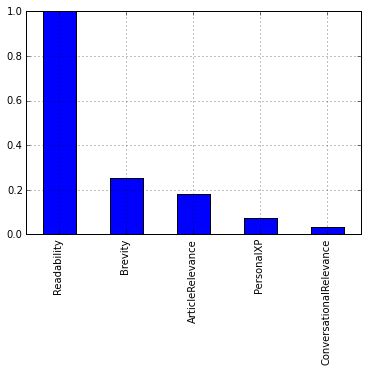

In [52]:
clf.coef_
nor_weights = clf.coef_[0] ** 2
nor_weights /= nor_weights.max()

feature_weights = {}

for label in feature_label:
    feature_weights[label] = {}


for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['NorSVM'] = nor_weights[i]
    feature_weights[feature_label[i]]['SVM'] = clf.coef_[0][i]
    
    
df = pd.DataFrame.from_dict(feature_weights, orient='index')
df = df.sort('NorSVM', ascending=0)
plt.figure()
df['NorSVM'].plot(kind='bar')
# hist = Bar(df, title="Feature weights by SVM", notebook=True)
# hist.show()

### Univariate feature selection wifh F-test



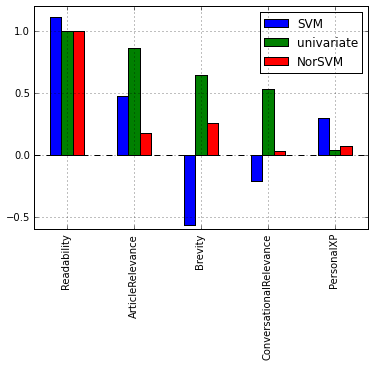

In [53]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X,y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['univariate'] = scores[i]
    
df = pd.DataFrame.from_dict(feature_weights, orient='index')

df = df.sort('univariate', ascending=0)
df.plot(kind='bar')

# plt.figure()
# df.plot(kind='bar')




### Linear regression

In [54]:
regr = linear_model.LogisticRegression()


In [55]:
scores = cross_validation.cross_val_score(regr, X, y, cv=5, scoring='f1')

scores

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


F1: 0.59 (+/- 0.11)


In [35]:
regr.fit(X, y)
regr.coef_

array([[ 0.5834571 , -0.48616264, -0.32364179,  0.167984  ,  0.93545777]])

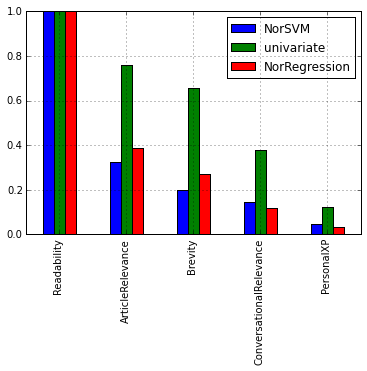

In [36]:
nor_weights = regr.coef_[0] ** 2
nor_weights /= nor_weights.max()



for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['NorRegression'] = nor_weights[i]
    feature_weights[feature_label[i]]['regression'] = regr.coef_[0][i]
    

    
df = pd.DataFrame.from_dict(feature_weights, orient='index')

df = df.sort('NorRegression', ascending=0)

df[:3]
plt.figure()
df[['NorSVM','univariate','NorRegression']].plot(kind='bar')
# hist = Bar(df, title="Univariate Score", notebook=True)
# hist.show()

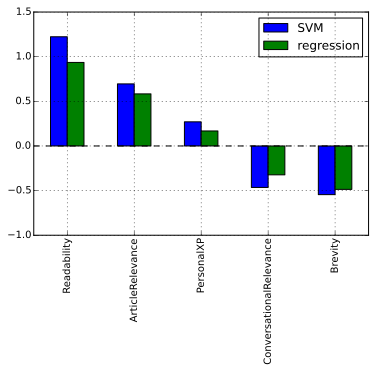

In [37]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

# %matplotlib [gui]
df = df.sort('regression', ascending=0)

df[:3]
plt.figure()
df[['SVM','regression']].plot(kind='bar')

In [38]:
coef = regr.coef_[0]

normal_coef = (coef / coef.max())*100

normal_coef

for i in range(len(feature_label)):
    print feature_label[i] + ': ' +  str(normal_coef[i]) +',' 

ArticleRelevance: 62.371292065,
Brevity: -51.9705598397,
ConversationalRelevance: -34.5971563598,
PersonalXP: 17.9574109785,
Readability: 100.0,


    Let's visualize the performance of classifier.

In [39]:
clf_decision = clf.decision_function(X)

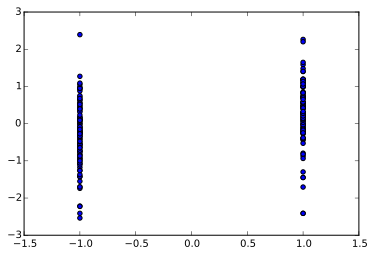

In [40]:
plt.scatter(y,clf_decision)

In [41]:
# desision_df = pd.DataFrame({'Label':y, 'Decision':clf_decision})
# desision_df[:3]

for i in clf_decision:
    clf_decision[i]
clf_decision[1]

IndexError: arrays used as indices must be of integer (or boolean) type

In [100]:
pos = [1,2,4,5,7,8]
data = [np.random.normal(size=100) for i in pos]

{u'bodies': [<matplotlib.collections.PolyCollection at 0x110056450>,
 u'cbars': <matplotlib.collections.LineCollection at 0x110078110>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x110056350>,
 u'cmins': <matplotlib.collections.LineCollection at 0x110070a90>}

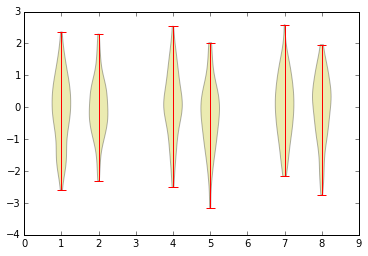

In [30]:
plt.violinplot(data,pos)